Nombre de doublons avant: 20
Nombre de doublons après: 0

Valeurs manquantes après remplissage:
age                  0
revenu_mensuel       0
anciennete_annees    0
type_contrat         0
secteur              0
region               0
depense_annuelle     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                300 non-null    float64
 1   revenu_mensuel     300 non-null    float64
 2   anciennete_annees  300 non-null    int64  
 3   type_contrat       300 non-null    object 
 4   secteur            300 non-null    object 
 5   region             300 non-null    object 
 6   depense_annuelle   300 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 18.8+ KB
None
         age  revenu_mensuel  anciennete_annees type_contrat    secteur  \
0  56.000000   249811.793478                 17         

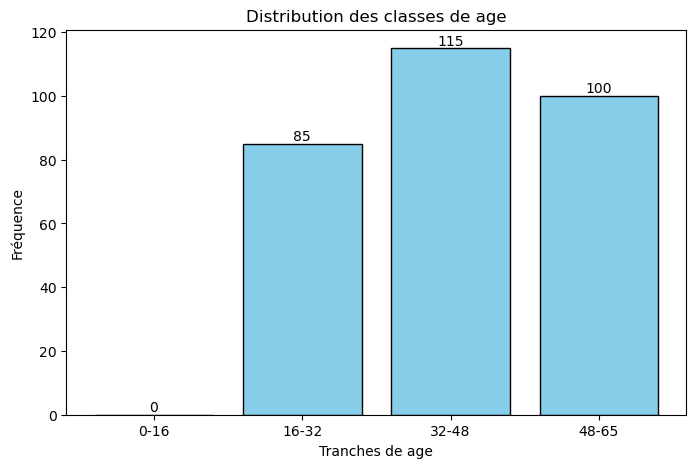

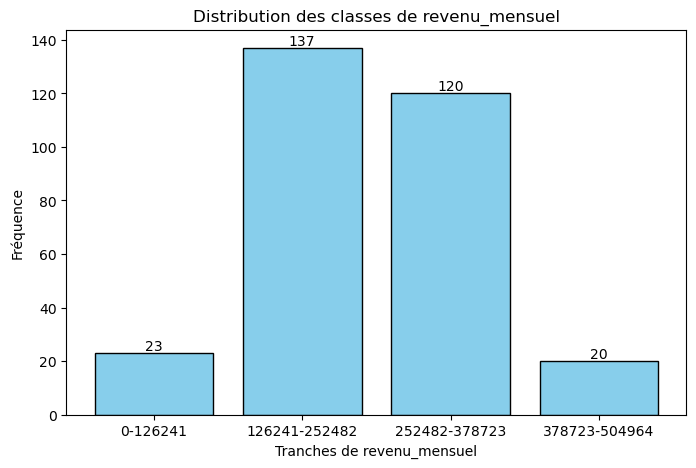

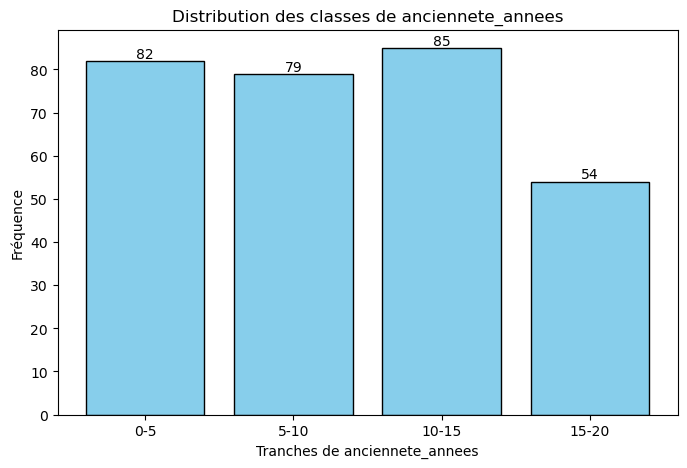

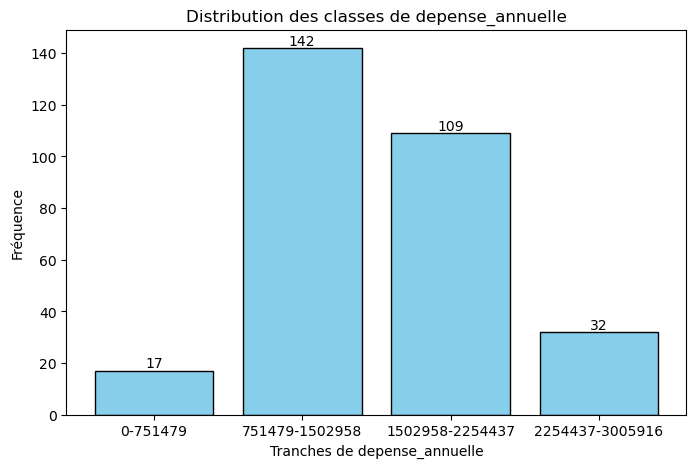

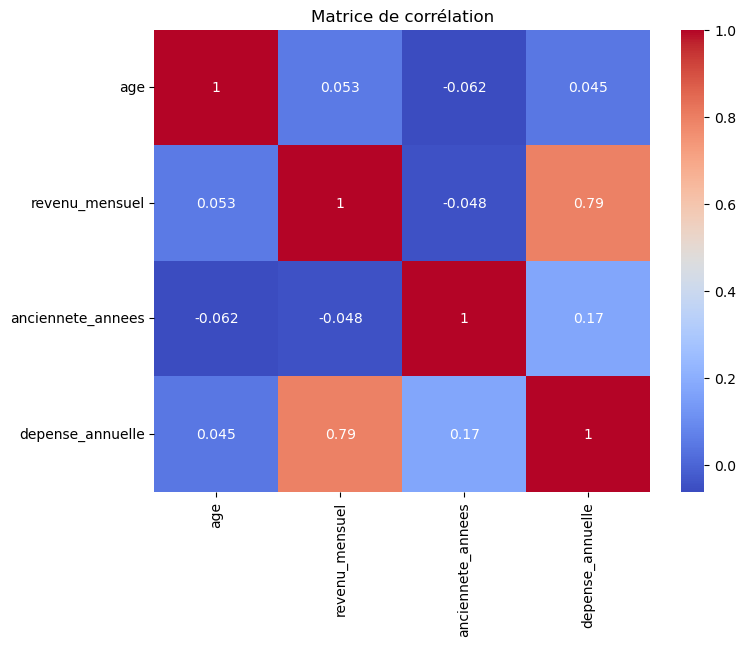

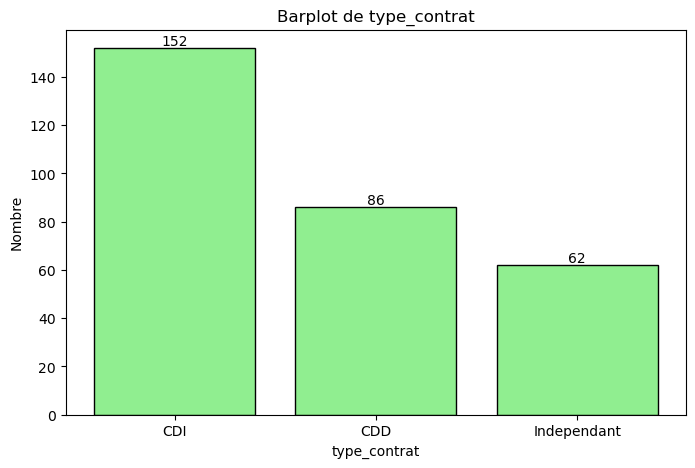

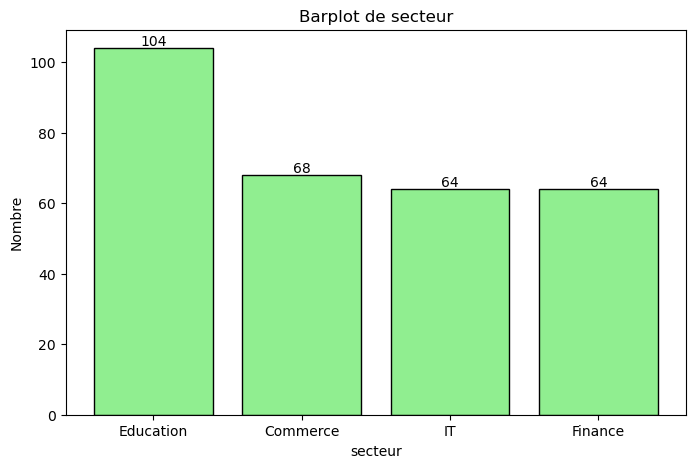

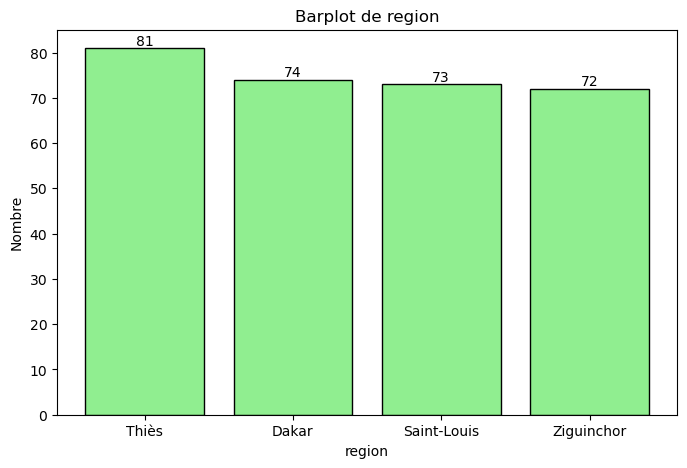

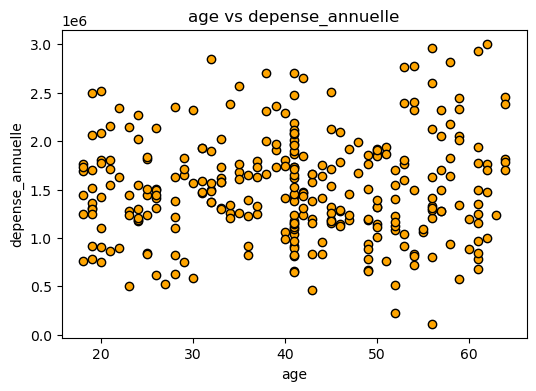

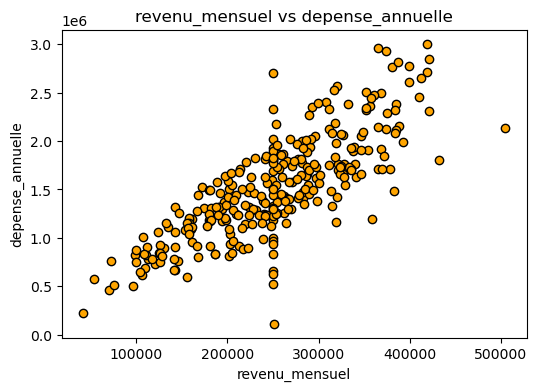

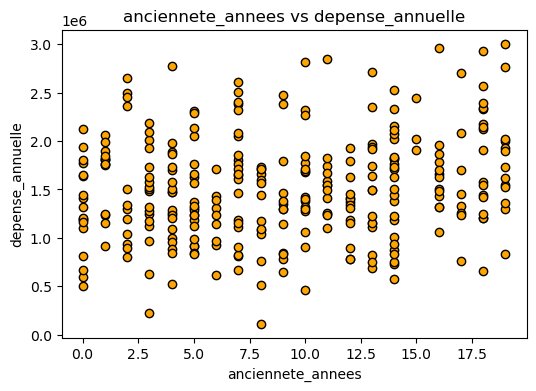

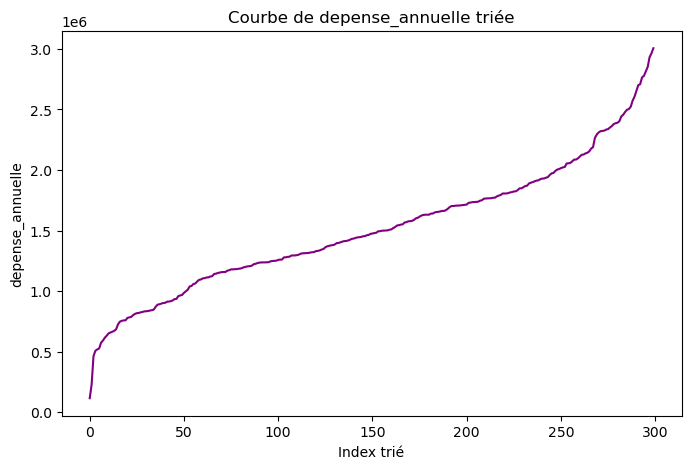


Évaluation du modèle :
MAE: 256466.61616666664
MSE: 108693028473.50357
RMSE: 329686.25763520016
R2: 0.5806339217229173
Client 1 : dépense annuelle prédite = 1104305.15 FCFA
Client 2 : dépense annuelle prédite = 2278844.35 FCFA
Client 3 : dépense annuelle prédite = 1210064.92 FCFA


In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Chargement du dataset
df = pd.read_csv(r"C:\Users\Ph\Downloads\dataset_entretien_ml_regression.csv")

# 2. Nettoyage
print("Nombre de doublons avant:", df.duplicated().sum())
df = df.drop_duplicates()
print("Nombre de doublons après:", df.duplicated().sum())

# Gestion des valeurs manquantes
numeric_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Correction des revenus négatifs
df['revenu_mensuel'] = df['revenu_mensuel'].apply(lambda x: x if x >= 0 else df[df['revenu_mensuel'] >= 0]['revenu_mensuel'].mean())

print("\nValeurs manquantes après remplissage:")
print(df.isnull().sum())

# 3. Exploration
print(df.info())
print(df.head())
print(df.describe())

# 3.a Histogrammes des colonnes numériques
for col in numeric_cols:
    max_val = df[col].max()
    bins = np.linspace(0, max_val+1, 5)
    labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
    df[f'{col}_group'] = pd.cut(df[col], bins=bins, labels=labels, right=False)
    
    counts = df[f'{col}_group'].value_counts().sort_index()
    
    plt.figure(figsize=(8,5))
    bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
    plt.title(f"Distribution des classes de {col}")
    plt.xlabel(f"Tranches de {col}")
    plt.ylabel("Fréquence")
    plt.show()

# 3.b Heatmap des corrélations numériques
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# 3.c Barplots des colonnes catégorielles
for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure(figsize=(8,5))
    bars = plt.bar(counts.index, counts.values, color='lightgreen', edgecolor='black')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')
    plt.title(f"Barplot de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre")
    plt.show()

# 3.d Scatter plots vs target
target_col = 'depense_annuelle'
for col in numeric_cols:
    if col != target_col:
        plt.figure(figsize=(6,4))
        plt.scatter(df[col], df[target_col], color='orange', edgecolor='black')
        plt.title(f"{col} vs {target_col}")
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.show()

# 3.e Courbe de la cible triée
df_sorted = df.sort_values(by=target_col)
plt.figure(figsize=(8,5))
plt.plot(df_sorted[target_col].values, color='purple')
plt.title(f"Courbe de {target_col} triée")
plt.xlabel("Index trié")
plt.ylabel(target_col)
plt.show()

# 4. Préprocessing et split
x = df.drop(target_col, axis=1)
y = df[target_col]

numeric_features = x.select_dtypes(include='number').columns.tolist()
categorical_features = x.select_dtypes(include='object').columns.tolist()

standard_features = numeric_features[:1]       # Standardisation pour la première colonne
minmax_features = numeric_features[1:]         # MinMax pour les autres

preprocessor = ColumnTransformer([
    ('standard', StandardScaler(), standard_features),
    ('minmax', MinMaxScaler(), minmax_features),
    ('cat', OneHotEncoder(), categorical_features)
])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 5. Modèle et pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(x_train, y_train)

# 6. Prédiction et évaluation
y_pred = pipeline.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nÉvaluation du modèle :")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# 7. Prédictions pour de nouveaux clients
new_clients = pd.DataFrame({
    'age': [35, 50, 28],
    'revenu_mensuel': [220000, 400000, 180000],
    'anciennete_annees': [5, 20, 2],
    'type_contrat': ['CDI', 'CDD', 'CDI'],
    'secteur': ['Finance', 'Commerce', 'Education'],
    'region': ['Dakar', 'Thiès', 'Dakar']
})

depenses_predites = pipeline.predict(new_clients)
for i, depense in enumerate(depenses_predites):
    print(f"Client {i+1} : dépense annuelle prédite = {float(depense):.2f} FCFA")
